In [85]:
import spuco.datasets as dsets
from spuco.datasets.base_spuco_dataset import SpuriousFeatureDifficulty
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
import pandas as pd
from collections import defaultdict
import os

Download modified MNIST data

In [86]:
trainset = dsets.spuco_mnist.SpuCoMNIST(
    root="data/mnist/",
    spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
    spurious_correlation_strength=0.995,
    classes=[[0,1],[2,3],[4,5],[6,7],[8,9]]
)
trainset.initialize()

testset = dsets.spuco_mnist.SpuCoMNIST(
    root="data/mnist/",
    spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
    spurious_correlation_strength=0.995,
    classes=[[0,1],[2,3],[4,5],[6,7],[8,9]],
    split='test'
)
testset.initialize()

valset = dsets.spuco_mnist.SpuCoMNIST(
    root="data/mnist/",
    spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
    spurious_correlation_strength=0.995,
    classes=[[0,1],[2,3],[4,5],[6,7],[8,9]],
    split='val'
)
valset.initialize()

100%|██████████| 11996/11996 [00:00<00:00, 46040.56it/s]


Check the data to see how it looks

2


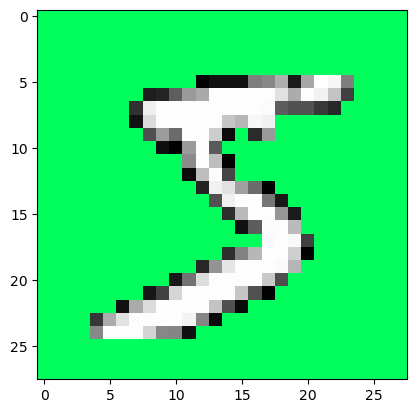

In [87]:
print(trainset[0][1])
array = np.transpose(np.array(trainset[0][0]), (1,2,0))
plt.imshow(array)

Define the architecture for the model we will be using.
First we use 2 convolution layers of size 5x5 and create 18 total images. We use a 2x2 window to maxpool the image and the activation function is Relu. Then we flatten the image and run it through a fully connected network of 288->64->5 neurons

In [88]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            nn.Conv2d(3,9,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(9,18,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(1,-1),
            nn.Linear(288,64),
            )
        self.relu = nn.ReLU()
        self.l = nn.Linear(64,5)

    def forward(self, x):
        x = self.net(x)
        x = self.relu(x)
        return self.l(x)
    

Data processing.
Training Batch size is 5.

In [89]:
scaler = StandardScaler()
batch_size = 5

train_labels = trainset.labels
train_images = np.array([trainset[i][0] for i in range(len(trainset))])
test_labels = testset.labels
test_images = np.array([testset[i][0] for i in range(len(testset))])
val_labels = valset.labels
val_images = np.array([valset[i][0] for i in range(len(valset))])

train_images = torch.tensor(train_images, dtype = torch.float32)
train_labels = torch.tensor(train_labels, dtype = torch.long)
test_images = torch.tensor(test_images, dtype = torch.float32)
test_labels = torch.tensor(test_labels, dtype = torch.long)
val_images = torch.tensor(val_images, dtype = torch.float32)
val_labels = torch.tensor(val_labels, dtype = torch.long)

train1 = TensorDataset(train_images, train_labels)
test1 = TensorDataset(test_images, test_labels)
val1 = TensorDataset(val_images, val_labels)

train = DataLoader(train1, batch_size)
test = DataLoader(test1,5)
val = DataLoader(val1, 5)

Training with AdamW optimizer and learning rate of 0.00005. The loss function is Cross Entropy Loss. We train for 30 epochs. We also incorporate a transform to normalize the data and aid the training process, and use a learning rate reducer to help with plateaus in the training

In [90]:
model = LeNet()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = torch.nn.CrossEntropyLoss()
train_loss = []
test_loss = []
transform = T.Compose([
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])
epochs = 100
best_loss = 100000
for epoch in range(epochs):
    model.train()
    tot_loss = 0
    for x,y in train:
        #x = transform(x)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        tot_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(tot_loss/len(train))

    tot_loss = 0
    model.eval()
    with torch.no_grad():
        for x,y in val:
            #x = transform(x)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            tot_loss += loss.item()
        test_loss.append(tot_loss/(len(val)))
    if best_loss > test_loss[-1]:
        best_loss = test_loss[-1]
        torch.save(model.state_dict(), 'Saved Data/models/model.pt')
    print(f"Epoch {epoch+1}: Training Loss = {train_loss[epoch]:.4f}, Validation Loss = {test_loss[epoch]:.4f}")

Epoch 1: Training Loss = 0.1069, Validation Loss = 0.0459
Epoch 2: Training Loss = 0.0416, Validation Loss = 0.0409
Epoch 3: Training Loss = 0.0391, Validation Loss = 0.0392
Epoch 4: Training Loss = 0.0380, Validation Loss = 0.0383
Epoch 5: Training Loss = 0.0371, Validation Loss = 0.0375
Epoch 6: Training Loss = 0.0361, Validation Loss = 0.0365
Epoch 7: Training Loss = 0.0350, Validation Loss = 0.0354
Epoch 8: Training Loss = 0.0338, Validation Loss = 0.0339
Epoch 9: Training Loss = 0.0323, Validation Loss = 0.0322
Epoch 10: Training Loss = 0.0306, Validation Loss = 0.0304
Epoch 11: Training Loss = 0.0288, Validation Loss = 0.0287
Epoch 12: Training Loss = 0.0273, Validation Loss = 0.0272
Epoch 13: Training Loss = 0.0258, Validation Loss = 0.0259
Epoch 14: Training Loss = 0.0246, Validation Loss = 0.0248
Epoch 15: Training Loss = 0.0234, Validation Loss = 0.0238
Epoch 16: Training Loss = 0.0224, Validation Loss = 0.0230
Epoch 17: Training Loss = 0.0215, Validation Loss = 0.0223
Epoch 

Visulize loss over each epoch

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

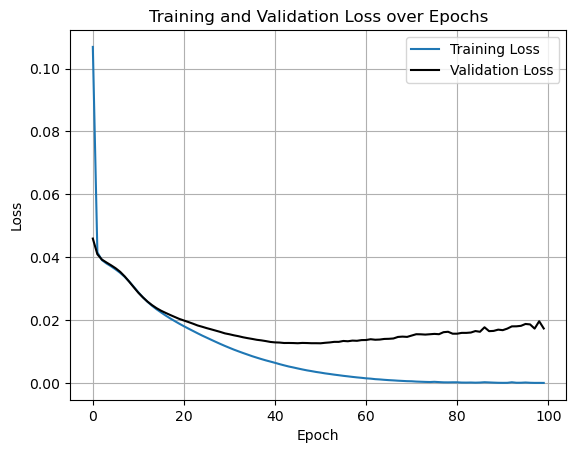

In [91]:
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, color='black', label = "Validation Loss")
plt.grid(True)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")

Test the accuracy of the model after training

In [107]:
model.load_state_dict(torch.load('Saved Data/models/model.pt', weights_only=True))
num_correct = 0
model.eval()
with torch.no_grad():
    for x,y in test:
        y_pred = model(transform(x))
        num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
print(f"{100*num_correct/(len(test) * 5):.2f}% accuracy on test dataset")

        

66.41% accuracy on test dataset


Save the processed data into files for later use

In [97]:
torch.save(train_images,'Saved Data/Data/train_images.pt')
torch.save(train_labels, 'Saved Data/Data/train_labels.pt')
torch.save(test_images, 'Saved Data/Data/test_images.pt')
torch.save(test_labels, 'Saved Data/Data/test_labels.pt')
torch.save(val_images, 'Saved Data/Data/val_images.pt')
torch.save(val_labels, 'Saved Data/Data/val_labels.pt')

Robust Accuracy: 0.00% over 53 occurances for group 50.0


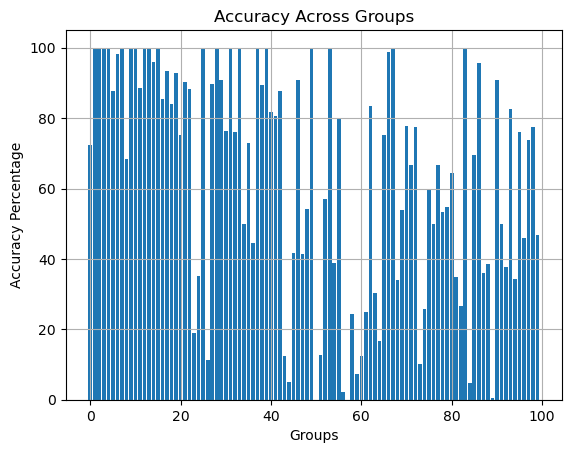

In [101]:
test_group_path = "Saved Data/Groups/testing_groups.csv"
if not os.path.exists(test_group_path):
    print("Please run the clustering to get the robust accuracy")
else:
    df = pd.read_csv('Saved Data/Groups/testing_groups.csv')

    class GroupData(Dataset):
        def __init__(self,images, labels, groups):
            self.image = images
            self.label = labels
            self.group = groups

        def __len__(self):
            return len(self.image)
        
        def __getitem__(self, index):
            return self.image[index], self.label[index], self.group[index]
        
    test_data = GroupData(test_images, test_labels, df['Labels'])
    test_dataloader = DataLoader(test_data, 100)

    group_acc = defaultdict(float)
    group_num = defaultdict(int)
    model.eval()
    for x,y,groups in test_dataloader:
        y_pred = model(transform(x))
        num_correct = (torch.argmax(y_pred, dim=1) == y)
        
        for group in groups.unique():
            group_mask = (groups == group)
            group_acc[group.item()] += torch.sum(num_correct[group_mask])
            group_num[group.item()] += len(num_correct[group_mask])

    plt.bar(df['Labels'].unique(),[100 * group_acc[g] / group_num[g] for g in df['Labels'].unique()])
    plt.xlabel("Groups")
    plt.ylabel("Accuracy Percentage")
    plt.title("Accuracy Across Groups")
    plt.grid()
    plt.plot()

    worst_group = min(df['Labels'].unique(), key = lambda g: group_acc[g] / group_num[g])
    print(f"Robust Accuracy: {100 * group_acc[worst_group] / group_num[worst_group]:.2f}% over {group_num[worst_group]} occurances for group {worst_group}")